# Classification (Part 2)

In the the first classification exercise scikit-learn was utilised to classify Twitter users as male or female. Vectorization was done via sklearn's CountVectorizer. At the end of the lab exercise, the preprocessing and tokenisation used by CountVectorizer were customised to give greater control of how the text was processed and features extracted. This actually allows for quite a number of features to be implemented, e.g.:

- POS tags, by pos-tagging during tokenisation, and returning the pos-tags instead of words.
- Function words, by setting the vocabulary of CountVectorizer to a function word list.
- Hashtags, mentions and/or emojis, by only returning these in the token list.
- Characters/graphemes, rather than codepoints, by "tokenising" with "\X".

But we are limited to counting things. Another issue is that the processing will be done multiple times each time the pipeline is ran (e.g. for gridsearch).

In this lab you will learn how to process texts in advance, saving the token lists and frequency lists produced, and allowing for other features to be extracted.

First, we do all the imports needed in one go. You may import other packages as needed.

In [1]:
import ftfy
import nltk
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

A couple of methods for showing classifier results (from 1st classification lab):

In [2]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (5, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

For POS tagger, incase these haven't been previously downloaded.

In [3]:
nltk.download('punkt')
nltk.download('maxent_treebank_pos_tagger')

[nltk_data] Downloading package punkt to /home/jay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/jay/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


True

Next we define our document object, along preprocessing tokenisation methods. These are taken (and slightly extended) from the Feature Extraction lab. The document will represent an instance in our classifier, e.g. it could be a collection of a user's Tweets, a single tweet, a longer article, etc.

In [4]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        
    def extract_features_from_text(self, text):
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens) #updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

We use the Twitter GB celebs again, but from JSON files with further metadata available (the data is slightly different from the first classification lab as it was collected later). The method below reads in the json file, extracts the metadata for the user, creates a new Document representing the user, and adds all of the Tweets (extracting features).

In [5]:
def import_celebs_json(folder):
    jsonfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".json")]
    for jf in jsonfiles:
        with open(jf) as f:
            data = json.load(f)
            handle = data['handle']
            gender = data['gender']
            age_range = data['age_range']
            english = data['english']
            birth_year = data['birth_year']
        print("Processing " + handle)
        doc = Document({'handle': handle, 'gender': gender, birth_year:'birth_year', 'age_range': age_range, 'english': english}) #include metadata
        for tweet in data['tweets']:
            doc.extract_features_from_text(tweet['text'])
        yield doc

Build the corpus by processing the folder of gb celebs. This will take a little while due to the pos-tagging, but it should only need doing once (unless you change the Document class).

In [6]:

corpus = []
#corpus.extend(import_celebs_json("celebs-gb-json"))
#corpus.extend(import_celebs_json("celebs-other-json"))


We use the gender metadata from the Documents as our label/class.

In [7]:
import pickle
'''
print('len:',len(corpus))
import copy

tt = copy.deepcopy(corpus)

with open('CelebFile-other', 'wb') as fp:
    pickle.dump(corpus, fp)
'''

with open('CombinedCelebFile', 'rb') as fp:
    corpus = pickle.load(fp)


In [8]:
y = [d.meta['gender'] for d in corpus]
X = corpus

We can also perform the usual train/test split.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

223 56
223 56


Now we have our train/test instances in our custom class to hold the features, we need to build a custom `Transformer` which takes in one dataset and returns a new dataset. Here we need to take in a list of `Document` objects and transform it into a set of features. We build a simple class for this, which overrides the transform method. The intention is for a list of `Document` objects to be passed into the transformer, and parameter-defined (callable) method is used to extract the featuress.

In [10]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

Below are some example methods for returning the token frequency list, pos frequency list, or some text statistics from the `Document`. These can be edited and added to as needed.

In [11]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_pos_fql(document):
    return document.pos_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

We build pipeline with the `DocumentProcessor` as the first step, extract POS tag frequencies as features. The output from the new `DocumentProcessor` is then passed to a [`DictVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer), which transforms the features into a vector (scipy.sparse matrix), which can be used with other sklearn steps. To demontrate, we pass to a Naive Bayes classifier.

In [12]:
model = Pipeline([
    ('processor', DocumentProcessor(process_method = get_pos_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [13]:
cv_scores = cross_validate(model, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 71.75%, sd = 6.83%, min = 63.16, max = 83.64
Precision: mean = 71.74%, sd = 5.89%, min = 66.23, max = 83.03
Recall: mean = 71.75%, sd = 6.83%, min = 63.16, max = 83.64
F1: mean = 70.99%, sd = 6.40%, min = 64.74, max = 83.02


## Feature Union

All the pipelines we have used so far have been simple linear sequences of steps. With [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion) we can have complex branched sequences, where different features, or different parts of the text are processed separately. The results are then concatenated together into a composite vector. We could, for example, read in a user's bio separately from the rest of their text, we could even utilise metadata (such as usernames to predict gender), or other data such as profile images.

Below we utilise different featuresets available from the Document instances and concatenate them together simply.

In [14]:
model2 = Pipeline([
    ('text_union', FeatureUnion(
        transformer_list = [
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [15]:
cv_scores = cross_validate(model, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 71.75%, sd = 6.83%, min = 63.16, max = 83.64
Precision: mean = 71.74%, sd = 5.89%, min = 66.23, max = 83.03
Recall: mean = 71.75%, sd = 6.83%, min = 63.16, max = 83.64
F1: mean = 70.99%, sd = 6.40%, min = 64.74, max = 83.02


## Classifying other labels

We have been working on binary classification of gender. Other user metadata can be predicted also, with the age_range and English variety being present (if you use the larger datasets provided).

Looking at age, there are 5 age ranges present, plus some marked as "unknown". We need to remove the "unknowns" as predicting as 'unknown' does not make sense. You could predict these unknowns with your trained classifier at the end.

In [16]:
set([d.meta['age_range'] for d in X])


{'25-34', '35-44', '45-54', '55-64', '65+', 'unknown'}

In [17]:
#tt = [d for d in X if d.meta['age_range'] != 'unknown']
for age in set([d.meta['age_range'] for d in X]):
    yy = [d for d in X if d.meta['age_range'] == age]
    print('age: ' , age , ' : ' , len(yy) )

age:  65+  :  20
age:  25-34  :  77
age:  45-54  :  64
age:  35-44  :  69
age:  unknown  :  12
age:  55-64  :  37


In [18]:
age_X = [d for d in X if d.meta['age_range'] != 'unknown']
#age_X = [d for d in X if d.meta['birth_year'] != 'unknown']
len(age_X)

267

3 instances have been removed. We need to extract the new labels also.

In [19]:
age_y = [d.meta['age_range'] for d in age_X]
#age_y = [d.meta['birth_year'] for d in age_X]

We do a train-test split as before.

In [20]:
age_X_train, age_X_test, age_y_train, age_y_test = train_test_split(age_X, age_y, test_size=0.2, random_state = 0, stratify=age_y)

We build a pipeline with feature union similar to earlier, except we are now also using grid search, including if to include funtion words or all words.

Creating MLP
Making Ensemble
fitting clf


/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/si

Accuracy:  0.3888888888888889
              precision    recall  f1-score   support

       25-34       0.50      0.75      0.60        16
       35-44       0.33      0.36      0.34        14
       45-54       0.25      0.15      0.19        13
       55-64       0.50      0.29      0.36         7
         65+       0.00      0.00      0.00         4

   micro avg       0.39      0.39      0.39        54
   macro avg       0.32      0.31      0.30        54
weighted avg       0.36      0.39      0.36        54

[[12  2  2  0  0]
 [ 6  5  2  0  1]
 [ 4  5  2  1  1]
 [ 0  3  1  2  1]
 [ 2  0  1  1  0]]


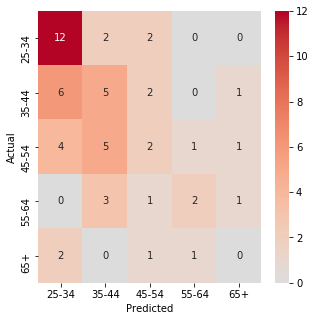

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostRegressor, VotingClassifier, RandomForestClassifier


######################### MLP #########################
print('Creating MLP')
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('pos', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pos_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', MLPClassifier(max_iter=600)), # to be set by grid search.
])
'''
param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_tokens_fql],
    'selector__k': [100, 'all'],
    'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100,100,100,100,100,100),(25,25,25,25,25) ],
                            'clf__activation': ['tanh', 'relu'],
                            'clf__solver': ['sgd', 'adam'],
                            'clf__alpha': [0.0001, 0.05],
                            'clf__learning_rate': ['constant','adaptive'],
}
'''

param_grid = {
 'clf__activation': ['relu'],
 'clf__alpha': [0.05],
 'clf__hidden_layer_sizes': (50, 100, 50),
 'clf__learning_rate': ['constant'],
 'clf__solver': ['adam'],
 'selector__k': ['all'],
 'union__word__processor__process_method': [get_tokens_fql],
             }

MLP_clf = GridSearchCV(model, cv = StratifiedKFold(n_splits=2, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )


######################### MLP #########################


#####################  RandomForest  ####################
RandomForestClassifier = Pipeline([
    ('text_union', FeatureUnion(
        transformer_list = [
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    #('clf', LogisticRegression(solver='liblinear', random_state=0)),
    ('clf', RandomForestClassifier()),
    #('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
])


param_grid = {
 #'clf__activation': ['relu'],
 #'clf__alpha': [0.05],
 #'clf__hidden_layer_sizes': (50, 100, 50),
 #'clf__learning_rate': ['constant'],
 #'clf__solver': ['adam'],
 #'selector__k': ['all'],
 #'union__word__processor__process_method': [get_tokens_fql],
             }

RandomForestClassifier_clf = GridSearchCV(RandomForestClassifier, cv = StratifiedKFold(n_splits=2, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

#####################  RandomForest  ####################

############# Logistic Regression ################
LogisticRegressionPipeline = Pipeline([
    ('text_union', FeatureUnion(
        transformer_list = [
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    
])

LogisticRegression_clf = GridSearchCV(LogisticRegressionPipeline, cv = StratifiedKFold(n_splits=2, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )



############# Logistic Regression ################


############### MULTINOMIAL
MB_pipe = Pipeline([
    ('text_union', FeatureUnion(
        transformer_list = [
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    #('clf', LogisticRegression(solver='liblinear', random_state=0)),
    #('clf', RandomForestClassifier()),
    ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
])


param_grid = {
 #'clf__activation': ['relu'],
 #'clf__alpha': [0.05],
 #'clf__hidden_layer_sizes': (50, 100, 50),
 #'clf__learning_rate': ['constant'],
 #'clf__solver': ['adam'],
 #'selector__k': ['all'],
 #'union__word__processor__process_method': [get_tokens_fql],
             }

MB_clf = GridSearchCV(MB_pipe, cv = StratifiedKFold(n_splits=2, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

############### MULTINOMIAL



print('Making Ensemble')

search = VotingClassifier(estimators=[('MLP', MLP_clf), ('MB',MB_clf), ('Rand_Forest', RandomForestClassifier_clf), ('LR', LogisticRegression_clf)])

print('fitting clf')

search.fit(age_X_train, age_y_train)

predictions = search.predict(age_X_test)

print("Accuracy: ", accuracy_score(age_y_test, predictions))
print(classification_report(age_y_test, predictions))
print(confusion_matrix(age_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(age_y_test,predictions), search.classes_)


In [22]:
#pd.DataFrame(MLP_clf.cv_results_)

In [23]:
#tt = search.estimators[0]
tt = search.estimators_[0]
pd.DataFrame(tt.cv_results_)

tt.best_params_


{'clf__activation': 'relu',
 'clf__alpha': 0.05,
 'clf__hidden_layer_sizes': 50,
 'clf__learning_rate': 'constant',
 'clf__solver': 'adam',
 'selector__k': 'all',
 'union__word__processor__process_method': <function __main__.get_tokens_fql(document)>}

## Exercise

Try adding and improving the features used for age classification (or language variant), and evaluate your results with different setups. You can choose to include the larger dataset if you wish, but be aware that running time will increase substantially. There may also be memory errors ([setting `memory` to a temp directory for the Pipeline may help](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline))

Marks will be given as follows.
- 3 marks will be given for a good range of additional or improved features (> 3), or advanced task (see below).
- 2 marks will be given for a completed analysis with some extra features.
- 1 mark will be given for a full attempt.
This exercise must be demonstrated by Week 19's lab.

### Advanced tasks:

- You could try predicting the precise age with a regression model (the age is in the json metadata). See: https://dl.acm.org/citation.cfm?id=2107651.
- Or you could try predicting age and gender together, either mutli-class pairs, or through a classification tree, e.g. predict gender first, then narrowing age ranges.
- Next week we'll be looking at indidual Tweets as "documents" or instances. You can try this now: change the json processor to create Documents for each Tweet, you can predict Gender or age based on a single Tweet, or Author (e.g. using Handle as the label). I suggest reducing the number of Authors to 10-20 if trying authorship attribution. With short tweets, it is probably better to binarise count features.

/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy:  0.46296296296296297
              precision    recall  f1-score   support

       25-34       0.57      0.81      0.67        16
       35-44       0.50      0.29      0.36        14
       45-54       0.33      0.46      0.39        13
       55-64       0.40      0.29      0.33         7
         65+       0.00      0.00      0.00         4

   micro avg       0.46      0.46      0.46        54
   macro avg       0.36      0.37      0.35        54
weighted avg       0.43      0.46      0.43        54

[[13  2  1  0  0]
 [ 5  4  5  0  0]
 [ 4  2  6  1  0]
 [ 0  0  5  2  0]
 [ 1  0  1  2  0]]


/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


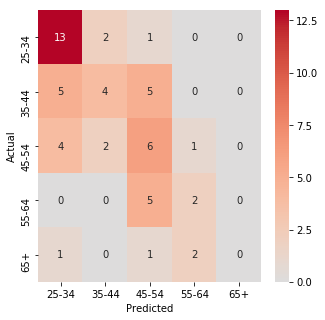

In [24]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('pos', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pos_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', None), # to be set by grid search.
])

param_grid={
 'clf': [MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)],
 'selector__k': ['all'],
 'union__word__processor__process_method': [get_tokens_fql],
           }


search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

search.fit(age_X_train, age_y_train)

predictions = search.predict(age_X_test)

print("Accuracy: ", accuracy_score(age_y_test, predictions))
print(classification_report(age_y_test, predictions))
print(confusion_matrix(age_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(age_y_test,predictions), search.classes_)




In [25]:
#tt = search.estimators[0]
#tt = search.estimators_[0]

pd.DataFrame(search.cv_results_)

tt.best_params_
tt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('pos', Pipeline(memory=None,
     steps=[('processor', DocumentProcessor(process_method=<function get_pos_fql at 0x7f878be64400>)), ('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        spar...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__activation': ['relu'], 'clf__alpha': [0.05], 'clf__hidden_layer_sizes': (50, 100, 50), 'clf__learning_rate': ['constant'], 'clf__solver': ['adam'], 'selector__k': ['all'], 'union__word__processor__process_method': [<function get_tokens_fql at 0x7f878f111ae8>]},
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scori

In [26]:
search.best_params_

{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 'selector__k': 'all',
 'union__word__processor__process_method': <function __main__.get_tokens_fql(document)>}

/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/si

/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jay/anacon

Accuracy:  0.46296296296296297
              precision    recall  f1-score   support

       25-34       0.57      0.81      0.67        16
       35-44       0.50      0.29      0.36        14
       45-54       0.33      0.46      0.39        13
       55-64       0.40      0.29      0.33         7
         65+       0.00      0.00      0.00         4

   micro avg       0.46      0.46      0.46        54
   macro avg       0.36      0.37      0.35        54
weighted avg       0.43      0.46      0.43        54

[[13  2  1  0  0]
 [ 5  4  5  0  0]
 [ 4  2  6  1  0]
 [ 0  0  5  2  0]
 [ 1  0  1  2  0]]


/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


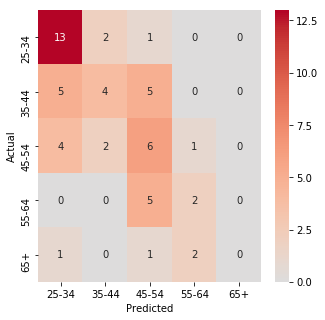

In [27]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('pos', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pos_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', None), # to be set by grid search.
])

param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_tokens_fql],
    'selector__k': [100, 'all'],
    'clf': [MultinomialNB(), LogisticRegression(solver='liblinear', random_state=0)],
}



search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

search.fit(age_X_train, age_y_train)

predictions = search.predict(age_X_test)

print("Accuracy: ", accuracy_score(age_y_test, predictions))
print(classification_report(age_y_test, predictions))
print(confusion_matrix(age_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(age_y_test,predictions), search.classes_)



